In [1]:
import numpy as np
import pandas as pd
import cooler
import bioframe

In [2]:
from cooltools.sandbox import obs_over_exp_cooler
import cooltools

In [3]:
from scipy.sparse import coo_matrix
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# clr = cooler.Cooler("./ALV-repo/Hap1-WT-combined.mcool::/resolutions/500000")
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [6]:
# Load a Hi-C map at a 1Mb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000000')

In [7]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


In [8]:
# calculate full expected (cis + trans)
expected_df = obs_over_exp_cooler.expected_full(
    clr,
    view_df=hg38_arms,
    smooth_cis=False,
    aggregate_trans=True,
    expected_column_name="expected",
    nproc=4,
)

INFO:root:Done calculating cis expected in 0.433 sec ...
INFO:root:Done calculating trans expected in 0.532 sec ...
INFO:root:Returning combined expected DataFrame.


In [9]:
# collect obs/exp for chunks of pixel table (in memory for 1Mb cooler)
results = []
for oe_chunk in obs_over_exp_cooler.obs_over_exp_generator(
        clr,
        expected_df,
        view_df=hg38_arms,
        expected_column_name="expected",
        oe_column_name='oe',
        chunksize=1_000_000,
    ):
    results.append(oe_chunk)
# concat chunks into single DataFrame - res_df - is a new pixel table - sparse matrix
res_df = pd.concat(results, ignore_index=True)
res_df.head()

INFO:root:Calculating observed over expected for pixels [0:52475]


,bin1_id,bin2_id,oe
0,0,0,NaN
1,0,1,NaN
2,0,2,1.836246
3,0,3,1.498967
4,0,4,1.633761


In [10]:
# res_df: sparse matrix -> dense matrix for plotting
N = len(clr.bins())
oe = coo_matrix(
    (res_df["oe"], (res_df["bin1_id"], res_df["bin2_id"])),
    shape=(N,N),
).toarray()
# make it symmetric ...
oe = oe + oe.T
print(f"generated symmetrix obs/exp matrix of size {N} X {N}")

generated symmetrix obs/exp matrix of size 327 X 327


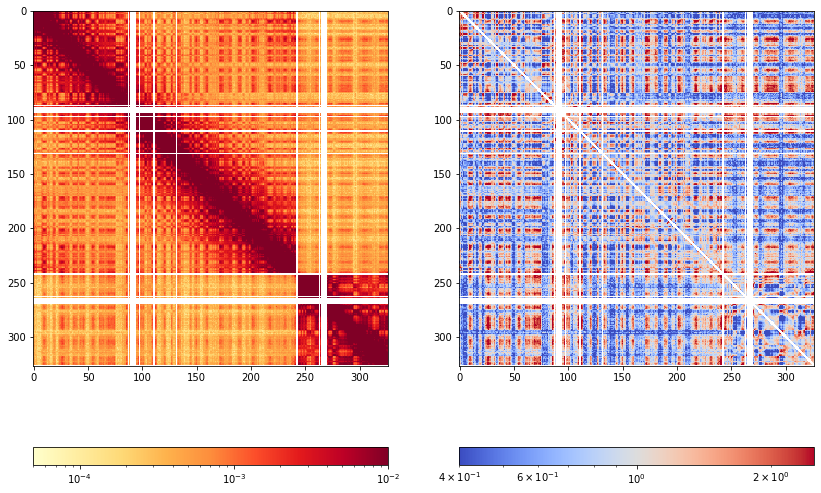

In [11]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = oe[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    obs,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")
img = axs[1].imshow(
    obs_exp,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")

### Try higher resolution data and write directly into cooler 

In [12]:
# try 10kb ...
clr = cooler.Cooler('./test.mcool::/resolutions/10000')

In [13]:
# generate bins table with weights=1, and NaN for bad bins ...
bins_oe = clr.bins()[:]
_bad_mask = bins_oe["weight"].isna()
bins_oe["weight"] = 1.
bins_oe.loc[_bad_mask,"weight"] = np.nan

In [14]:
# re-calculate full expected (cis + trans) at higher resolution
expected_df = obs_over_exp_cooler.expected_full(
    clr,
    view_df=hg38_arms,
    smooth_cis=False,
    aggregate_trans=True,
    expected_column_name="expected",
    nproc=4,
)

INFO:root:Done calculating cis expected in 16.787 sec ...
INFO:root:Done calculating trans expected in 7.697 sec ...
INFO:root:Returning combined expected DataFrame.


In [15]:
# setup a generator (lazy) of obs/exp pixels
oe_pixels_stream = obs_over_exp_cooler.obs_over_exp_generator(
    clr,
    expected_df,
    view_df=hg38_arms,
    expected_column_name="expected",
    oe_column_name='oe',
    chunksize=10_000_000
)

In [ ]:
# write oe_pixels_stream into cooler - with custom column "oe" (can do "count":float for higlass)
cooler.create_cooler(
    cool_uri = "fun.cool",
    bins = bins_oe,
    pixels = oe_pixels_stream,
    columns=["oe"],
    dtypes={"oe":np.float64},
)

INFO:root:Calculating observed over expected for pixels [0:10000000]
INFO:cooler.create:Writing chunk 0: /data/old_desktop/src/cooltools/cooltools/sandbox/tmpq67gm7hp.multi.cool::0
INFO:cooler.create:Creating cooler at "/data/old_desktop/src/cooltools/cooltools/sandbox/tmpq67gm7hp.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
/home/sergpolly/miniconda3/envs/devcool/lib/python3.9/site-packages/cooler/core.py:123: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif is_categorical(data):
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:root:Calculating observed over expected for pixels [10000000:20000000]
INFO:cooler.create:Writing chunk 1: /data/old_desktop/src/cooltools/cooltools/sandbox/tmpq67gm7hp.multi.cool::1
INFO:cooler.create:Creating cooler at "/data/old_desktop/src/cooltools/cooltools/sandbox/tmpq67gm7hp.multi.cool

In [ ]:
# plot observed and stitched obs/exp side by side directly from the new cooler
istart, iend = 23_000, 25_000
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = cooler.Cooler("fun.cool").matrix(field="oe")[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    obs,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")

# make sure zeros are displayed as "lowest" obs/exp according to the colormap
cm = plt.cm.get_cmap("coolwarm")
cm.set_under(cm(0))

img = axs[1].imshow(
    obs_exp+10**-8,
    interpolation="none",
    cmap=cm,
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
    # add color to the "under" - to avoid adding "floor" to obs_exp
    # 
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")